In [54]:
# import lib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import make_moons,make_classification,make_regression,make_circles
import sys
from mpl_toolkits.mplot3d import Axes3D 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA,KernelPCA
np.random.seed(23)
np.set_printoptions(precision=3,suppress=True)
plt.style.use('seaborn')

from tensorflow.examples.tutorials.mnist import input_data

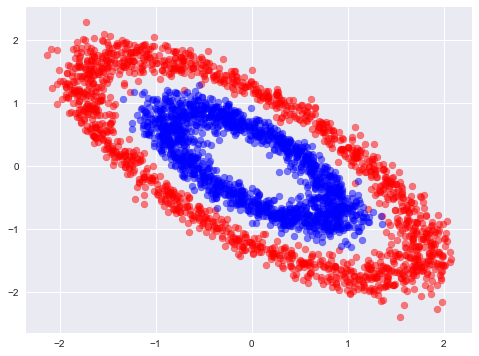

In [67]:
# See the data 
from sklearn.datasets.samples_generator import make_blobs
# X, y = make_blobs(n_samples=1000, centers=3, n_features=2,random_state=0,cluster_std =2)
X, y = make_circles(n_samples=3000, factor=.5, noise=.09)
X = X @ np.array([[1,0],[1,2]])
# X,y = make_regression(n_samples=400, n_features=1,noise=5); X = np.concatenate((X,y[:,None]),1) 

# ======== WE ARE CENTERING AND STD =======
X[:,1] = -X[:,1]
X = (X - X.mean(0))/X.std(0)
# ======== WE ARE CENTERING AND STD =======

plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
# plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.show()

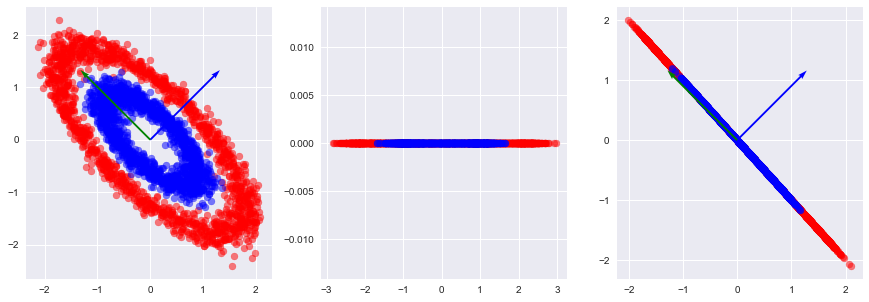

In [68]:
# traditional PCA

# 1. projection
cov = X.T @ X / X.shape[1]
evalue,evector = np.linalg.eig(cov)
idx = np.argsort(evalue)[::-1]
evecs = evector[:,idx]
projected = X @ evecs[:,0]
recovered = projected[:,None] @ evecs[:,0][:,None].T

# 2. recover
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
# plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 3, 2)
# plt.scatter(projected,np.zeros(len(projected)), color='red', alpha=0.5)
plt.scatter(projected[y==0], np.zeros((len(projected)//2)), color='red', alpha=0.5)
plt.scatter(projected[y==1], np.zeros((len(projected)//2)), color='blue', alpha=0.5)


plt.subplot(1, 3, 3)
# plt.scatter(recovered[:, 0], recovered[:,1], color='red', alpha=0.5)
plt.scatter(recovered[y==0, 0], recovered[y==0, 1], color='red', alpha=0.5)
plt.scatter(recovered[y==1, 0], recovered[y==1, 1], color='blue', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

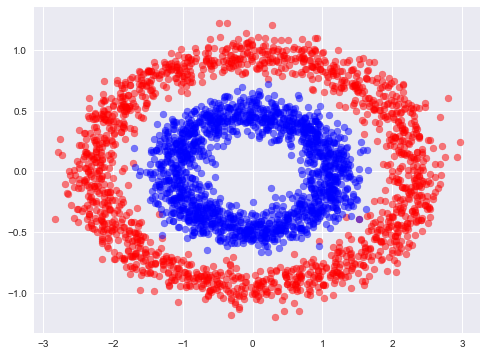

In [69]:
# PCA Sklearn 
one = PCA(n_components=2).fit_transform(X)
# plt.figure(figsize=(8,6))
# plt.scatter(one[y==0], np.zeros((len(one)//2)),  color='red', alpha=0.05)
# plt.scatter(one[y==1], np.zeros((len(one)//2)), color='blue', alpha=0.05)
# plt.show()

plt.figure(figsize=(8,6))
plt.scatter(one[y==0, 0], one[y==0, 1], color='red', alpha=0.5)
plt.scatter(one[y==1, 0], one[y==1, 1], color='blue', alpha=0.5)
plt.show()

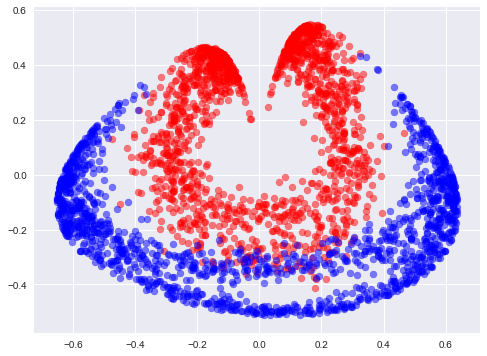

In [70]:
# PCA Sklearn 
dsad = KernelPCA(n_components=2,gamma=2, kernel="rbf").fit_transform(X)
# plt.figure(figsize=(8,6))
# plt.scatter(dsad[y==0], np.zeros((len(one)//2)),  color='red', alpha=0.05)
# plt.scatter(dsad[y==1], np.zeros((len(one)//2)), color='blue', alpha=0.05)
# plt.show()

plt.figure(figsize=(8,6))
plt.scatter(dsad[y==0, 0], dsad[y==0, 1], color='red', alpha=0.5)
plt.scatter(dsad[y==1, 0], dsad[y==1, 1], color='blue', alpha=0.5)
plt.show()

In [71]:
#  act functions 
def g(x) :     return np.arctan(x)
def gg(x):     return np.tan(x)
def g_grad(x): return 1/(1+x**2)
def gg_grad(x):return 1/(np.cos(x)*2+1e-8)

class PCA_layer():

    def __init__(self,inc,outc,act=g,d_act=g_grad):
        
        self.w =self.sym_decorrelation(np.random.normal(size=(inc,outc)))
        self.a =self.stand(np.random.normal(size=(outc)))
        self.b =self.stand(np.random.normal(size=(outc)))
        self.c =self.stand(np.random.normal(size=(outc)))
#         self.a =np.ones(outc)
#         self.b =np.ones(outc)
#         self.c =np.zeros(outc)

        self.act = act; self.d_act = d_act
        
        self.mw,self.vw = np.zeros_like(self.w),np.zeros_like(self.w)
        self.ma,self.va = np.zeros_like(self.a),np.zeros_like(self.a)
        self.mb,self.vb = np.zeros_like(self.b),np.zeros_like(self.b)
        self.mc,self.vc = np.zeros_like(self.c),np.zeros_like(self.c) 
    
    def feed_linear(self,input_value):
        self.input = input_value
        self.layer = self.input @ self.w
        var = self.w.T @ self.input.T @ self.input @ self.w
        return self.layer,var
    
    def back_linear(self):
        gradw     = -2*self.input.T @ self.input @ self.w 
        grad_pass = -2*self.input   @ self.w     @ self.w.T
        
        self.mw   = beta1 * self.mw + (1-beta1) * gradw
        self.vw   = beta2 * self.vw + (1-beta2) * gradw ** 2
        adam_midw = (self.mw / (1-beta1)) * learning_rate/(np.sqrt(self.vw/(1-beta2)) + adam_e)
        self.w    = self.sym_decorrelation(self.w - adam_midw) 
        return grad_pass
        
    def feed_non(self,input_value):
        self.input = input_value
        self.layer = self.input @ self.w 
        self.layerA= self.a * self.act(self.b * self.layer) + self.c
        var = self.w.T @ self.input.T @ self.input @ self.w
        return self.layerA,var
    
    def back_non(self,gradient):
        
        grada = (gradient * self.act(self.b * self.layer)).mean(0)
        gradb = (gradient * self.a * self.d_act(self.b * self.layer) * self.layer).mean(0)
        gradc = gradient.mean(0)
        
        gradw = self.input.T @(gradient * self.a * self.d_act(self.b * self.layer) * self.b)   -2 * self.input.T @ self.input @ self.w 
        grad_pass = (gradient * self.a * self.d_act(self.b * self.layer) * self.b)  @ self.w.T -2 * self.input   @ self.w     @ self.w.T
        
#         gradw = self.input.T @(gradient * self.a * self.d_act(self.b * self.layer) * self.b) 
#         grad_pass = (gradient * self.a * self.d_act(self.b * self.layer) * self.b)  @ self.w.T 
        
        self.ma   = beta1 * self.ma + (1-beta1) * grada
        self.va   = beta2 * self.va + (1-beta2) * grada ** 2
        adam_mida = (self.ma / (1-beta1)) * learning_rate/(np.sqrt(self.va/(1-beta2)) + adam_e)
        self.a    = self.stand(self.a - adam_mida)
        
        self.mb   = beta1 * self.mb + (1-beta1) * gradb
        self.vb   = beta2 * self.vb + (1-beta2) * gradb ** 2
        adam_midb = (self.mb / (1-beta1)) * learning_rate/(np.sqrt(self.vb/(1-beta2)) + adam_e)
        self.b    = self.stand(self.b - adam_midb)      

        self.mc   = beta1 * self.mc + (1-beta1) * gradc
        self.vc   = beta2 * self.vc + (1-beta2) * gradc ** 2
        adam_midc = (self.mc / (1-beta1)) * learning_rate/(np.sqrt(self.vc/(1-beta2)) + adam_e)
        self.c    = self.stand(self.c - adam_midc)
        
        self.mw   = beta1 * self.mw + (1-beta1) * gradw
        self.vw   = beta2 * self.vw + (1-beta2) * gradw ** 2
        adam_midw = (self.mw / (1-beta1)) * learning_rate/(np.sqrt(self.vw/(1-beta2)) + adam_e)
        self.w    = self.sym_decorrelation(self.w - adam_midw)
        
        return grad_pass
    
#     def stand(self,a): return a/(np.sqrt(np.sum(a**2)))
    def stand(self,a): return (a-a.mean())/a.std()
    def norm(self,w):  return w/(np.sqrt(np.sum(w**2)))
    def sym_decorrelation(self,W):
        """ Symmetric decorrelation
        i.e. W <- (W * W.T) ^{-1/2} * W
        """
        s, u = np.linalg.eigh(np.dot(W, W.T))
        # u (resp. s) contains the eigenvectors (resp. square roots of
        # the eigenvalues) of W * W.T
        return np.dot(np.dot(u * (1./(np.sqrt(s+1e-8)+1e-8)), u.T), W)
    
# need to fix this later
class batch_norm():
    
    def __init__(self):
        pass
    
    def feed(self,x,eps=1e-8):
        
        N, D = x.shape

        #step1: calculate mean
        mu = 1./N * np.sum(x, axis = 0)

        #step2: subtract mean vector of every trainings example
        xmu = x - mu

        #step3: following the lower branch - calculation denominator
        sq = xmu ** 2

        #step4: calculate variance
        var = 1./N * np.sum(sq, axis = 0)

        #step5: add eps for numerical stability, then sqrt
        sqrtvar = np.sqrt(var + eps)

        #step6: invert sqrtwar
        ivar = 1./sqrtvar

        #step7: execute normalization
        xhat = xmu * ivar

        self.cache = (xhat,xmu,ivar,sqrtvar,var)

        return xhat
    def back(self,dout,eps=1e-8):
        xhat,xmu,ivar,sqrtvar,var = self.cache
        
        #get the dimensions of the input/output
        N,D = dout.shape

        #step9
        dgammax = dout #not necessary, but more understandable

        #step8
        dxhat = dgammax 

        #step7
        divar = np.sum(dxhat*xmu, axis=0)
        dxmu1 = dxhat * ivar

        #step6
        dsqrtvar = -1. /(sqrtvar**2) * divar

        #step5
        dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar

        #step4
        dsq = 1. /N * np.ones((N,D)) * dvar

        #step3
        dxmu2 = 2 * xmu * dsq

        #step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

        #step1
        dx2 = 1. /N * np.ones((N,D)) * dmu

        #step0
        dx = dx1 + dx2

        return dx

In [ ]:
learning_rate = 100; beta1=0.9; beta2=0.9999; adam_e = 1e-8 

l1 = PCA_layer(2,3)
l1b= batch_norm()
l2 = PCA_layer(3,3)
l2b= batch_norm()
l3 = PCA_layer(3,2)

mini_batch_size    = 20
training_iteration = 100

copyX = np.copy(X)
for iter in range(training_iteration):

    copyX = shuffle(copyX)
    for current_batch_index in range(0,len(X),mini_batch_size):
        current_batch = copyX[current_batch_index:current_batch_index+mini_batch_size]
        layer1,layer1_var = l1.feed_non(current_batch)
        layer1bn = l1b.feed(layer1)
        layer2,layer2_var = l2.feed_non(layer1bn)
        layer2bn = l2b.feed(layer2)
        layer3,layer3_var = l3.feed_linear(layer2bn)

        sys.stdout.write("Iter: " + str(iter) + " " + str(layer1_var.mean() + layer2_var.mean() + layer3_var.mean()) + '\r')
        sys.stdout.flush()
        
        grad3 = l3.back_linear()
        grad2bn = l2b.back(grad3)
        grad2 = l2.back_non(grad2bn)
        grad1bn = l1b.back(grad2)
        grad1 = l1.back_non(grad1bn)
   
layer1,layer1_var = l1.feed_non(X)
layer1bn = l1b.feed(layer1)
layer2,layer2_var = l2.feed_non(layer1bn)
layer2bn = l2b.feed(layer2)
layer3,layer3_var = l3.feed_linear(layer2bn)

plt.figure(figsize=(8,6))
plt.scatter(layer3[y==0, 0], layer3[y==0, 1], color='red', alpha=0.5)
plt.scatter(layer3[y==1, 0], layer3[y==1, 1], color='blue', alpha=0.5)
plt.show()

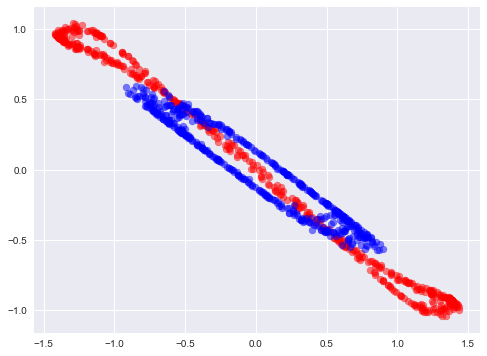

In [38]:
layer1,layer1_var = l1.feed_non(X)
layer1bn = l1b.feed(layer1)
layer2,layer2_var = l2.feed_non(layer1bn)
layer2bn = l2b.feed(layer2)
layer3,layer3_var = l3.feed_linear(layer2bn)


trace1 = go.Scatter3d(
    x=layer1[y==0,0],
    y=layer1[y==0,1],
    z=layer1[y==0,2],
    mode='markers',
    line=dict(color='red',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
trace2 = go.Scatter3d(
    x=layer1[y==1,0],
    y=layer1[y==1,1],
    z=layer1[y==1,2],
    mode='markers',
    line=dict(color='blue',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
data = [trace1,trace2]
fig  = go.Figure(data=data)
iplot(fig)


trace1 = go.Scatter3d(
    x=layer2[y==0,0],
    y=layer2[y==0,1],
    z=layer2[y==0,2],
    mode='markers',
    line=dict(color='red',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
trace2 = go.Scatter3d(
    x=layer2[y==1,0],
    y=layer2[y==1,1],
    z=layer2[y==1,2],
    mode='markers',
    line=dict(color='blue',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
data = [trace1,trace2]
fig  = go.Figure(data=data)
iplot(fig)

plt.figure(figsize=(8,6))
plt.scatter(layer3[y==0, 0], layer3[y==0, 1], color='red', alpha=0.5)
plt.scatter(layer3[y==1, 0], layer3[y==1, 1], color='blue', alpha=0.5)
plt.show()